In [34]:
import random
from collections import Counter

import numpy as np
import pandas as pd
from sqlalchemy import create_engine

## Get photo ids and create label dictionary 

In [35]:
eng = create_engine('sqlite:///db/data.sqlite3', echo=False)

# get array of all image ids that aren't associated with any blank label 
sql = """
select distinct img_url_hash
from data
where img_url_hash not in 
  (select img_url_hash from data where data_category is '')
"""
res = eng.execute(sql)
ids = np.array([row[0] for row in res.fetchall()])

# get lookup dict for image id -> label
labels = {}
for iid in ids:
    sql = "select data_category from data where img_url_hash = ? and data_category like '%Comics%'"
    rows = eng.execute(sql, (iid, )).fetchall()
    # label 1 if a cartoon appears
    if rows:
        labels.update({iid: 1})
    # label 0 if it doesn't
    else:
        labels.update({iid: 0})


In [39]:
# Check totals against some things we know about data


counts = Counter([v for v in labels.values()])
print(counts[0])
print(counts[1])

# assert counts[0] == 745
# assert counts[1] == 178

# assert labels['3b01461ac1ab71813b7ec4dd63ee6e59'] == 1
# assert labels['02fb7b34ab71235d9d59b34cec6dabe3'] == 0


796
127


## Create test train and validation datasets

In [40]:
import warnings
from PIL.Image import DecompressionBombWarning

from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from skimage import io, exposure, transform

# suppress 'decompression bomb' warning, caused by very large images
warnings.simplefilter('ignore', DecompressionBombWarning)

def path_to_tensor(img_path, grayscale=False):
    """Take a path to an image file and return a 4D tensor for Keras"""
    img = image.load_img(img_path, target_size=(299, 299), grayscale=grayscale,
                         interpolation='bicubic')
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 299, 299, number of channels)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, grayscale=False):
    """Take a list of image file paths and return 4D tensors for Keras"""
    list_of_tensors = [path_to_tensor(img_path, grayscale=grayscale) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

def get_data(ids):
    # split data randomly into test, train and validation datasets
    train_ids, valid_test_ids = train_test_split(ids, test_size=0.25, shuffle=True)
    vt_split = int(len(valid_test_ids) // 2)
    valid_ids = valid_test_ids[:vt_split]
    test_ids = valid_test_ids[vt_split:]

    # get paths to images
    train_paths = ['images/{}.jpg'.format(id) for id in train_ids]
    valid_paths = ['images/{}.jpg'.format(id) for id in valid_ids]
    test_paths = ['images/{}.jpg'.format(id) for id in test_ids]
    
    # get tensors from images and rescale values in range 0 to 1
    x_train = paths_to_tensor(train_paths, grayscale=True) / 255
    x_valid = paths_to_tensor(valid_paths, grayscale=True) / 255
    x_test = paths_to_tensor(test_paths, grayscale=True) / 255

    # get labels from label lookup dict
    y_train = np.array([labels[id] for id in train_ids])
    y_valid = np.array([labels[id] for id in valid_ids])
    y_test = np.array([labels[id] for id in test_ids])
    
    return (x_train, y_train), (x_valid, y_valid), (x_test, y_test), test_ids

(x_train, y_train), (x_valid, y_valid), (x_test, y_test), test_ids = get_data(ids)



100%|██████████| 116/116 [00:39<00:00,  2.92it/s]


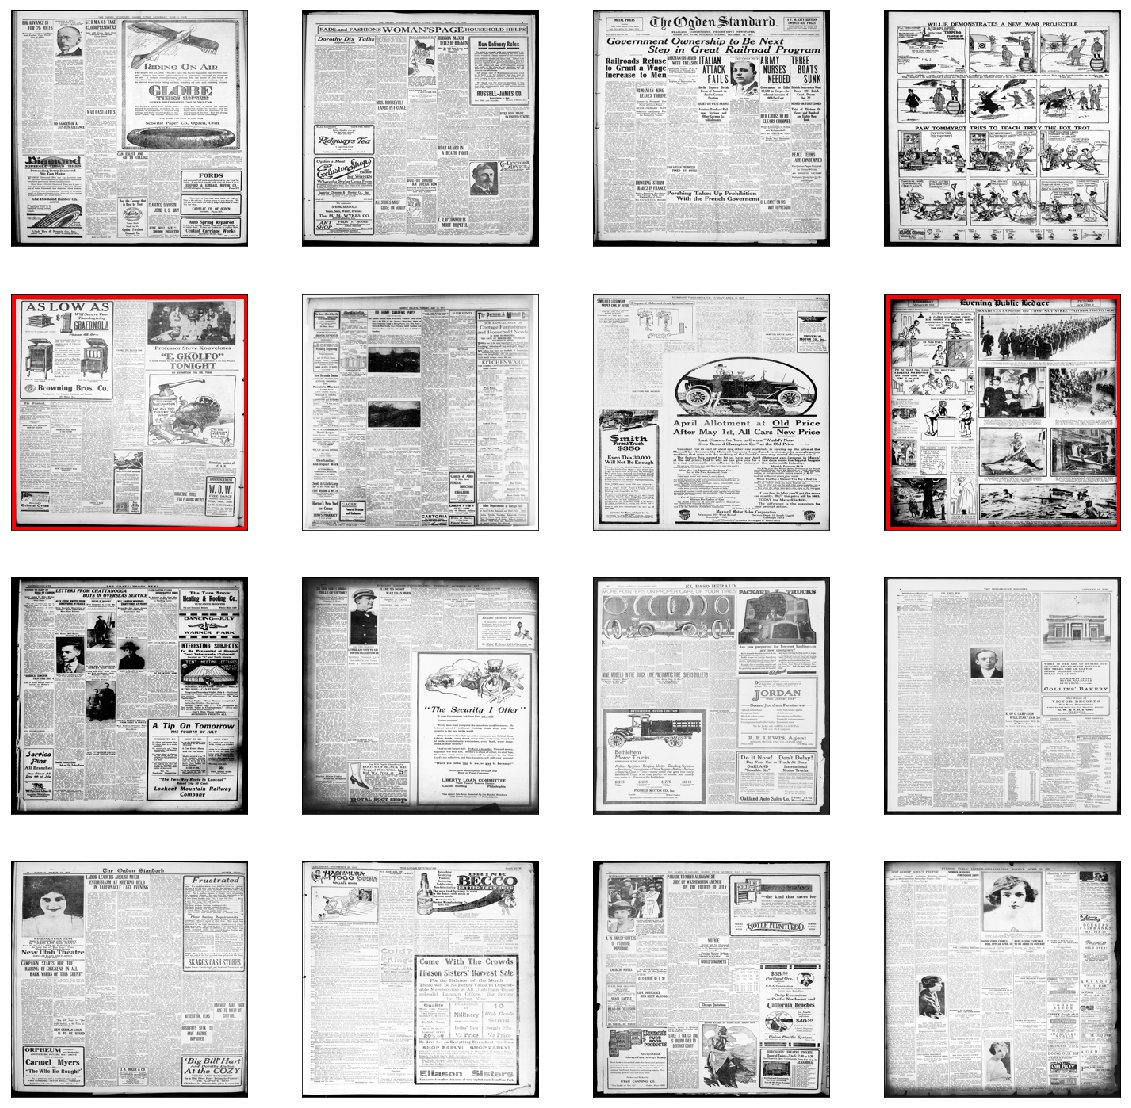

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig = plt.figure(figsize=(20, 20))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]), cmap='gray')
    if y_train[i]:
        rect = patches.Rectangle((4, 4), 293, 293, linewidth=4, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


In [42]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator()

datagen_train.fit(x_train)

In [55]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization

model = Sequential()

# first conv layer
model.add(Conv2D(
    filters=16,
    kernel_size=2,
    padding='same',
    use_bias=False,
    input_shape=(299, 299, 1),
    kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# second conv layer
model.add(Conv2D(filters=32, kernel_size=2, padding='same',
                 use_bias=False, kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# third conv layer
model.add(Conv2D(filters=64, kernel_size=2, padding='same',
                 use_bias=False, kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# dense layer
model.add(Flatten())
model.add(Dense(512, use_bias=False, kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# output layer
model.add(Dense(1, use_bias=False, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 299, 299, 16)      64        
_________________________________________________________________
activation_41 (Activation)   (None, 299, 299, 16)      0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 299, 299, 16)      64        
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 149, 149, 32)      2048      
_________________________________________________________________
activation_42 (Activation)   (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 149, 149, 32)      128       
__________

In [56]:
# compile the model
model.compile(
    loss='binary_crossentropy', #loss='categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)

In [57]:
from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 10

checkpointer = ModelCheckpoint(
    filepath='aug_model.weights.best.hdf5',
    verbose=1,
    save_best_only=True
)

model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=2,
    callbacks=[checkpointer],
    validation_data=(x_valid, y_valid),
    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/10
 - 71s - loss: 1.0802 - acc: 0.5979 - val_loss: 3.1292 - val_acc: 0.1652

Epoch 00001: val_loss improved from inf to 3.12918, saving model to aug_model.weights.best.hdf5
Epoch 2/10
 - 71s - loss: 0.4413 - acc: 0.8130 - val_loss: 0.7948 - val_acc: 0.5565

Epoch 00002: val_loss improved from 3.12918 to 0.79481, saving model to aug_model.weights.best.hdf5
Epoch 3/10
 - 68s - loss: 0.2954 - acc: 0.8904 - val_loss: 0.6258 - val_acc: 0.6870

Epoch 00003: val_loss improved from 0.79481 to 0.62584, saving model to aug_model.weights.best.hdf5
Epoch 4/10
 - 66s - loss: 0.2001 - acc: 0.9389 - val_loss: 0.6323 - val_acc: 0.6696

Epoch 00004: val_loss did not improve from 0.62584
Epoch 5/10
 - 68s - loss: 0.1312 - acc: 0.9732 - val_loss: 0.4036 - val_acc: 0.7739

Epoch 00005: val_loss improved from 0.62584 to 0.40357, saving model to aug_model.weights.best.hdf5
Epoch 6/10
 - 68s - loss: 0.0828 - acc: 0.9911 - val_loss: 0.2526 - val_acc: 0.9217

Epoch 00006: val_loss improved from 0.40357

In [58]:
# load the weights with the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

# get test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.948275862069
